In [62]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import imageio
from PIL import Image
from skimage.registration import phase_cross_correlation
import matplotlib.animation as animation
import pylab as pl
from IPython import display
import time
from scipy.stats import poisson
import os
import sys
import importlib

In [63]:
!pwd

/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/Files


In [64]:
dir_path = "/gpfs/cfel/user/butolama/Bragg_NF_Ptycho/pyxtools/Files"
impath = dir_path + "/polystyrene/1000X_2.jpg"
img = Image.open(impath)

print(f" size of the image is {img.size} ")

 size of the image is (2880, 2160) 


In [65]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [66]:
def prep_img(img, target_size):
    '''
    Parameters:
    img : image that needs to be prepared
    target size : (tuple) target array size eg. (n, m)
    
    Returns: 
    a 2D image array which is
    - resized to the target size
    - normalized
    '''
    N, M = img.size
    img =  img.convert("L")
    # Resize the image
    img = np.array(img)

    n1 = target_size[0]//2
    print(n1)
    rl = N//2 - n1 
    rh = N//2 + n1
    cl = M//2 - n1 
    ch = M//2 + n1

    print(f"{ rl, rh, cl, ch}")
    img = img [ cl : ch, rl:rh]
    
   
    
    img = img/img.max()
    return img


In [67]:
target_size = (2*1024, 2*1024)
img = prep_img(img = img, target_size = target_size)


1024
(416, 2464, 56, 2104)


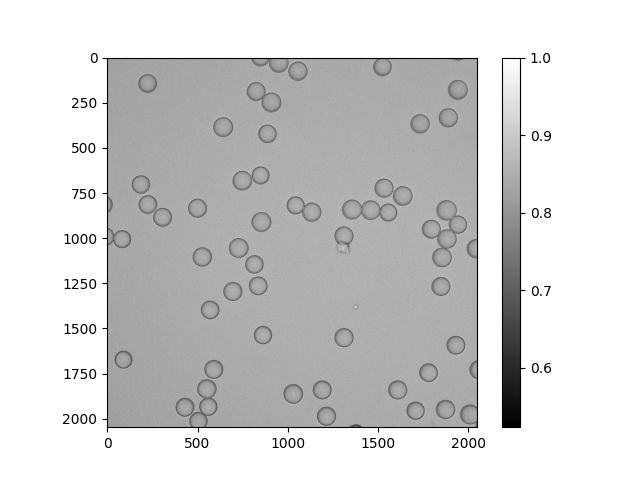

In [68]:

%matplotlib ipympl
plt.figure()
plt.imshow(img, cmap = 'gray')
plt.colorbar()

In [69]:
img.shape

(2048, 2048)

In [75]:
from scipy import ndimage

image_size = (1024, 1024)
zoom_fac = image_size[0]/ target_size[0]
img_final = ndimage.zoom(img,zoom_fac )

In [76]:
print(zoom_fac)

0.5


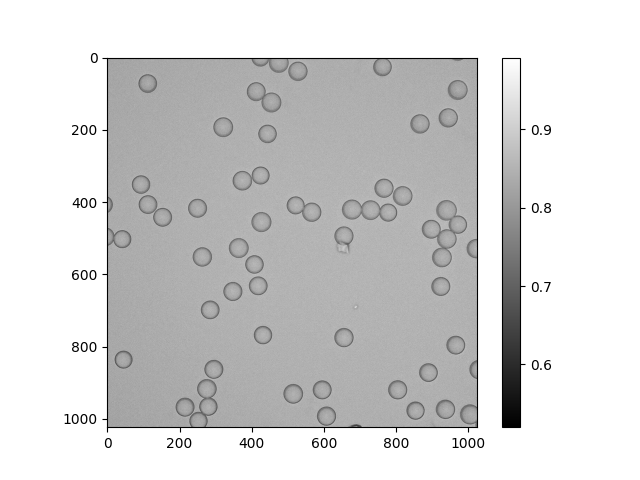

In [77]:
%matplotlib ipympl
plt.figure()
plt.imshow(img_final, cmap = 'gray')
plt.colorbar()

In [90]:
# high-pass filtering

def high_pass(arr, filter_size):
    n1 , m1 = arr.shape
    n2, m2 = filter_size
    rl = n1//2 - n2//2
    rh = n1//2 + n2//2
    cl = m1//2 - m2//2
    ch = m1//2 + m2//2

    high_pass_filt = np.ones_like(arr)
    high_pass_filt[rl:rh, cl:ch] = 0

    arr_FT = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(arr)))

    filtered_arr_FT = high_pass_filt *arr_FT

    filtered_arr = np.abs( np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(filtered_arr_FT))) )
    
    return filtered_arr, high_pass_filt


In [103]:
## Now creating a dark field image



dark_img, filter_used = high_pass(img_final, filter_size= (2, 2))

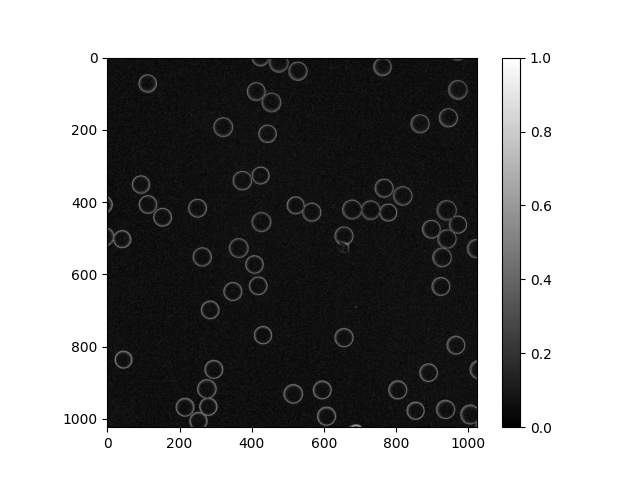

In [108]:

%matplotlib ipympl
plt.figure()
plt.imshow(dark_img, cmap = 'gray')
plt.colorbar()

In [ ]:
# Normalizing the dark image as well
dark_img = (dark_img - dark_img.min())/(dark_img.max() - dark_img.min())

In [109]:
# Saving bright and dark images for the simulations
np.save('bright_beads.npy', img_final)
np.save('dark_beads.npy', dark_img)


In [ ]:
# Comparisions of different high-pass filters

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from typing import Tuple, Union, Optional

def create_circular_mask(shape: Tuple[int, int], center: Optional[Tuple[int, int]] = None, 
                        radius: float = None) -> np.ndarray:
    """
    Create a circular mask.
    
    Args:
        shape: (height, width) of the mask
        center: (y, x) center coordinates. If None, uses image center
        radius: Radius of the circle. If None, uses min(shape)//4
    
    Returns:
        Binary mask with 1s inside the circle, 0s outside
    """
    h, w = shape
    if center is None:
        center = (h // 2, w // 2)
    if radius is None:
        radius = min(h, w) // 4
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    mask = dist_from_center <= radius
    return mask.astype(float)

def create_gaussian_filter(shape: Tuple[int, int], sigma: float, 
                          high_pass: bool = True, center: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """
    Create a Gaussian filter.
    
    Args:
        shape: (height, width) of the filter
        sigma: Standard deviation of Gaussian (controls cutoff frequency)
        high_pass: If True, creates high pass (1 - gaussian), else low pass
        center: Center of the filter. If None, uses image center
    
    Returns:
        Gaussian filter array
    """
    h, w = shape
    if center is None:
        center = (h // 2, w // 2)
    
    Y, X = np.ogrid[:h, :w]
    dist_squared = (X - center[1])**2 + (Y - center[0])**2
    gaussian = np.exp(-dist_squared / (2 * sigma**2))
    
    if high_pass:
        return 1 - gaussian
    else:
        return gaussian

def create_butterworth_filter(shape: Tuple[int, int], cutoff_freq: float, order: int = 2,
                             high_pass: bool = True, center: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """
    Create a Butterworth filter (smooth transition, no ringing).
    
    Args:
        shape: (height, width) of the filter
        cutoff_freq: Cutoff frequency (in pixels from center)
        order: Filter order (higher = sharper transition)
        high_pass: If True, creates high pass, else low pass
        center: Center of the filter. If None, uses image center
    
    Returns:
        Butterworth filter array
    """
    h, w = shape
    if center is None:
        center = (h // 2, w // 2)
    
    Y, X = np.ogrid[:h, :w]
    dist = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    
    # Avoid division by zero
    dist = np.maximum(dist, 1e-10)
    
    if high_pass:
        butterworth = 1 / (1 + (cutoff_freq / dist)**(2 * order))
    else:
        butterworth = 1 / (1 + (dist / cutoff_freq)**(2 * order))
    
    return butterworth

def improved_high_pass(arr: np.ndarray, 
                      filter_type: str = 'gaussian',
                      cutoff_param: Union[float, Tuple[int, int]] = None,
                      circular_aperture: bool = False,
                      aperture_radius: float = None,
                      **kwargs) -> Tuple[np.ndarray, np.ndarray]:
    """
    Improved high pass filter with multiple filter types and reduced ringing artifacts.
    
    Args:
        arr: Input image array
        filter_type: 'gaussian', 'butterworth', 'rectangular' (original method)
        cutoff_param: 
            - For gaussian: sigma value (default: min(shape)//8)
            - For butterworth: cutoff frequency in pixels (default: min(shape)//8)  
            - For rectangular: (height, width) of cutoff region
        circular_aperture: Apply circular aperture to limit frequency range
        aperture_radius: Radius of circular aperture (default: min(shape)//2.5)
        **kwargs: Additional parameters for specific filters
            - order: Butterworth filter order (default: 2)
            - center: Custom center point
    
    Returns:
        Tuple of (filtered_image, filter_used)
    """
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        raise ValueError("Input must be a 2D numpy array")
    
    n1, m1 = arr.shape
    center = kwargs.get('center', (n1 // 2, m1 // 2))
    
    # Create the base high pass filter
    if filter_type.lower() == 'gaussian':
        sigma = cutoff_param if cutoff_param is not None else min(n1, m1) // 8
        high_pass_filt = create_gaussian_filter(arr.shape, sigma, high_pass=True, center=center)
        
    elif filter_type.lower() == 'butterworth':
        cutoff_freq = cutoff_param if cutoff_param is not None else min(n1, m1) // 8
        order = kwargs.get('order', 2)
        high_pass_filt = create_butterworth_filter(arr.shape, cutoff_freq, order, 
                                                  high_pass=True, center=center)
        
    elif filter_type.lower() == 'rectangular':
        # Original method with improvements
        if cutoff_param is None:
            cutoff_param = (min(n1, m1) // 4, min(n1, m1) // 4)
        
        n2, m2 = cutoff_param
        rl = max(0, n1//2 - n2//2)
        rh = min(n1, n1//2 + n2//2)
        cl = max(0, m1//2 - m2//2) 
        ch = min(m1, m1//2 + m2//2)
        
        high_pass_filt = np.ones_like(arr, dtype=float)
        high_pass_filt[rl:rh, cl:ch] = 0
        
    else:
        raise ValueError(f"Unknown filter_type: {filter_type}. Use 'gaussian', 'butterworth', or 'rectangular'")
    
    # Apply circular aperture if requested
    if circular_aperture:
        radius = aperture_radius if aperture_radius is not None else min(n1, m1) // 2.5
        circular_mask = create_circular_mask(arr.shape, center, radius)
        high_pass_filt *= circular_mask
    
    # Apply the filter in frequency domain
    arr_FT = np.fft.fftshift(np.fft.fft2(arr))
    filtered_arr_FT = high_pass_filt * arr_FT
    filtered_arr = np.fft.ifft2(np.fft.ifftshift(filtered_arr_FT))
    
    # Return real part for real input, complex for complex input
    if np.isrealobj(arr):
        filtered_arr = np.real(filtered_arr)
    
    return filtered_arr, high_pass_filt

def plot_filter_comparison(arr: np.ndarray, filters_config: list, figsize: Tuple[int, int] = (15, 10)):
    """
    Compare different high pass filters side by side.
    
    Args:
        arr: Input image
        filters_config: List of dicts with filter parameters
        figsize: Figure size
    """
    n_filters = len(filters_config)
    fig, axes = plt.subplots(2, n_filters + 1, figsize=figsize)
    
    if n_filters == 0:
        return
    
    # Handle single filter case
    if n_filters == 1:
        axes = axes.reshape(2, -1)
    
    # Plot original image
    axes[0, 0].imshow(np.abs(arr), cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(arr))) + 1), cmap='hot')
    axes[1, 0].set_title('Original FFT (log scale)')
    axes[1, 0].axis('off')
    
    # Plot filtered results
    for i, config in enumerate(filters_config):
        filtered_img, filter_used = improved_high_pass(arr, **config)
        
        # Plot filtered image
        axes[0, i + 1].imshow(np.abs(filtered_img), cmap='gray')
        axes[0, i + 1].set_title(f"{config.get('filter_type', 'Unknown')} Filter")
        axes[0, i + 1].axis('off')
        
        # Plot filter response
        axes[1, i + 1].imshow(filter_used, cmap='hot')
        axes[1, i + 1].set_title(f"Filter Response")
        axes[1, i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage and comparisons
def demo_improved_filters(img_array):
    """
    Demonstrate the improved filters with your image.
    """
    # Configuration for different filters
    filters_to_compare = [
        {
            'filter_type': 'rectangular',
            'cutoff_param': (10, 10)
        },
        {
            'filter_type': 'gaussian', 
            'cutoff_param': 20,  # sigma
            'circular_aperture': False
        },
        {
            'filter_type': 'gaussian',
            'cutoff_param': 20,  # sigma  
            'circular_aperture': True,
            'aperture_radius': min(img_array.shape) // 3
        },
        {
            'filter_type': 'butterworth',
            'cutoff_param': 25,  # cutoff frequency
            'order': 2,
            'circular_aperture': True
        }
    ]
    
    # Compare filters
    plot_filter_comparison(img_array, filters_to_compare)
    
    return filters_to_compare



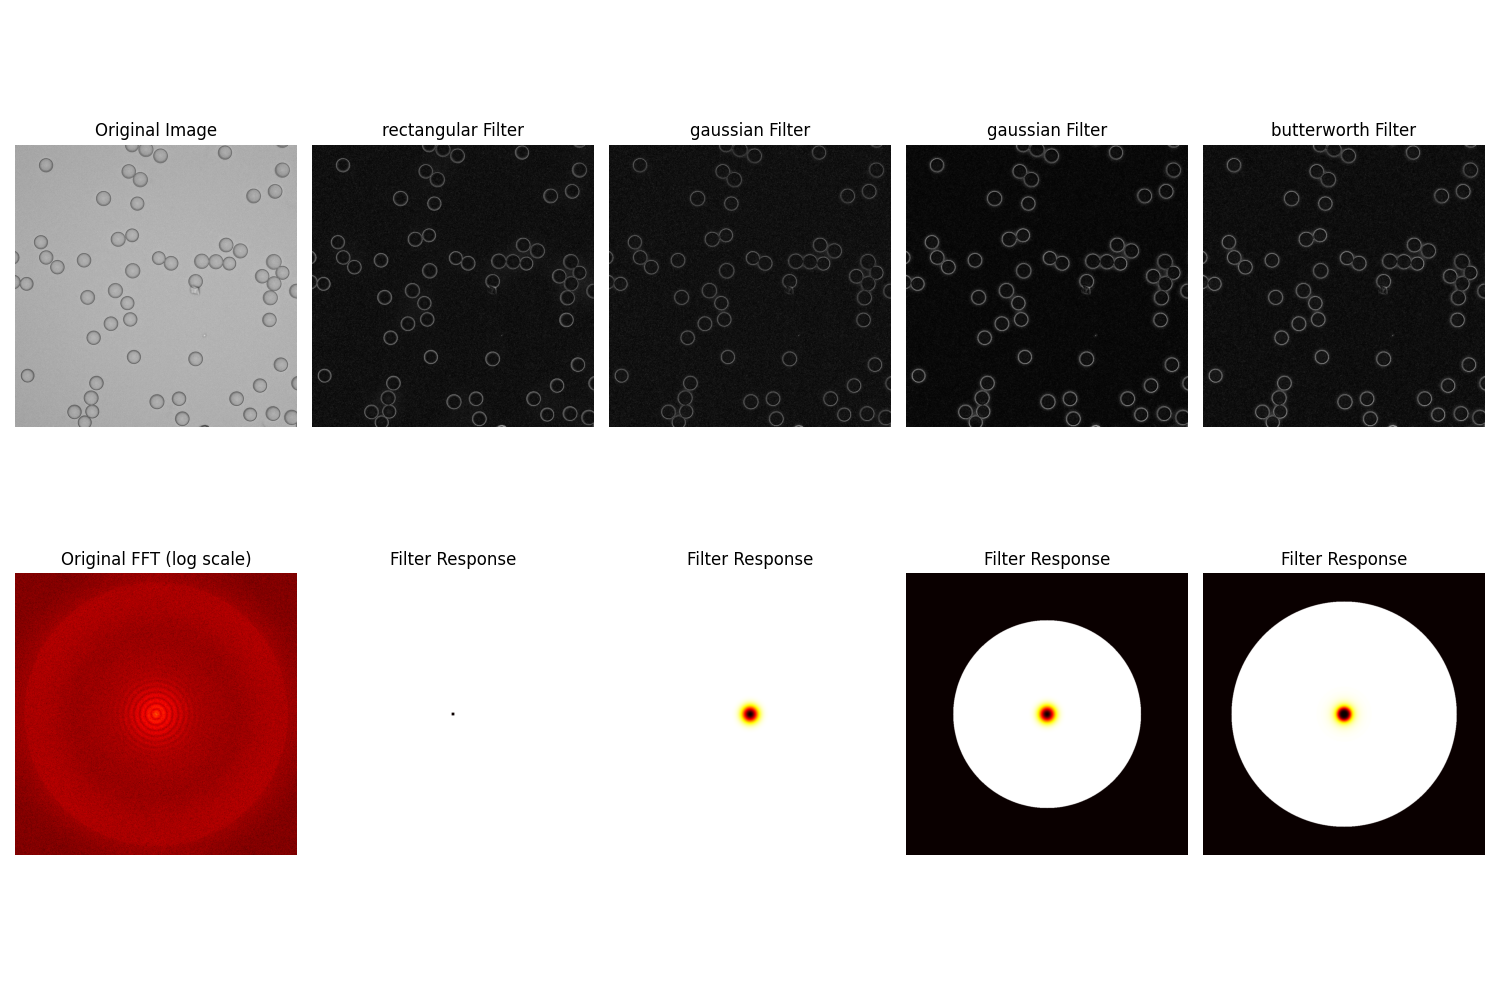

In [106]:
# Usage examples:

# Basic usage - Gaussian filter (recommended)
filtered_img, filter_response = improved_high_pass(
    img_final, 
    filter_type='gaussian',
    cutoff_param=20  # sigma - adjust based on your image size
)

# Butterworth filter with circular aperture (best for minimal ringing)
filtered_img, filter_response = improved_high_pass(
    img_final,
    filter_type='butterworth', 
    cutoff_param=25,    # cutoff frequency
    order=4,            # higher order = sharper transition
    circular_aperture=True,
    aperture_radius=min(img_final.shape) // 3
)

# Compare all methods
demo_filters = demo_improved_filters(img_final)
